# Using the new found cleaning and feature engineering to experiment further with stacking

In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Specific tf libraries
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
# BOOST
import xgboost
import lightgbm


## 1 - Any bagging

In [ ]:
scores = []
csv_paths = []
submission_path = "ensemble_predictions/big_bagging_1"
csv_bagging(scores, csv_paths, submission_path)

## 2 - Stacking

In [2]:
%run ../common_utils.py
train, test, metaData = load_all_data()

### XGB advisor 1 😎: all features - predicting floor price

In [4]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street"] #, "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = ["street"]

# Load data
train, test, metaData = load_all_data()
# Clean data. 
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=True, fillNan=False)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    add_some_more_features=False                                                            
    )
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# Drop
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [5]:
price_per_square_meter = train_targets/train['area_total'] # real price / real_area

In [6]:
xgb_advisor_1 = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15,
                                 subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1,
                                 reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

xgb_oof_train_1, xgb_oof_test_1, scores_1 = get_oof_xgboost(xgb_advisor_1, train_labels.drop(['area_total'],axis=1),
                                                      np.log(price_per_square_meter), test_labels.drop(['area_total'],axis=1))

In [7]:
print(scores_1)

[0.20252494570910018, 0.1719402910622423, 0.19194384452156768, 0.18187339676857273, 0.23624429647388234]


In [80]:
np.savez("oofs/xgb_oof_train_area", xgb_oof_train_1)
np.savez("oofs/xgb_oof_test_area", xgb_oof_test_1)

### XGB advisor 2 😎: Even more features - as well as area total - predicting price

In [8]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street"] #, "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = ["street"]

# Load data
train, test, metaData = load_all_data()
# Clean data. 
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=True, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    add_some_more_features=True                                                            
    )
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# Drop
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

C:\School\høst 2021\TDT4173-ML\common_utils.py:1467: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_labels = train_labels.fillna(train_labels.median()) # Boolean
C:\School\høst 2021\TDT4173-ML\common_utils.py:1476: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_labels = test_labels.fillna(test_labels.median()) # Boolean


minMax


In [9]:
xgb_advisor_2 = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15,
                                 subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1,
                                 reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

xgb_oof_train_2, xgb_oof_test_2, scores_2 = get_oof_xgboost(xgb_advisor_2, train_labels,
                                                      train_targets, test_labels)

In [10]:
print(scores_2)

[0.21366608257200162, 0.17480404267524746, 0.19900553175201274, 0.18699747945287365, 0.2390275085244918]


In [79]:
np.savez("oofs/xgb_oof_train_price", xgb_oof_train_2)
np.savez("oofs/xgb_oof_test_price", xgb_oof_test_2)

### DL advisor 1 - Predicting area_price

In [81]:
%run ../common_utils.py

In [82]:
# Mostly the ones correlated to price.
float_numerical_features = ["area_total", "area_kitchen", "area_living", "latitude", "longitude", "ceiling"]

int_numerical_features = ["floor", "stories", "rooms", "bathrooms_shared", "bathrooms_private", "balconies", "constructed"]

cat_features = ["district", "material", "parking", "seller"]

bool_features = []

features = ["building_id", "street"] + float_numerical_features + int_numerical_features + cat_features + bool_features

# Many of the features was just added to help clean/engineer other features.
droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories', "street",
            "rel_living", "bathrooms_shared", "bathrooms_private", "theta"] 

In [83]:
# Load data
train, test, metaData = load_all_data()

In [84]:
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=False, fillNan=True)

C:\School\høst 2021\TDT4173-ML\common_utils.py:1508: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_labels = train_labels.fillna(train_labels.median()) # Boolean
C:\School\høst 2021\TDT4173-ML\common_utils.py:1517: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_labels = test_labels.fillna(test_labels.median()) # Boolean


In [85]:
# Feature engineering
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=False,
    add_weak_features=False,
    add_dist_to_metro=True,
    add_close_to_uni=False,
    add_dist_to_hospital=False,
    add_floor_features=False,
    add_street_info=True,
    )

In [86]:
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")

minMax


In [87]:
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels,
                                            cat_features, drop_old=True)

In [88]:
# Droptable
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

In [89]:
price_per_square_meter = train_targets/train['area_total']

In [96]:
model_params = ([18, 18, 18], tensorflow.nn.leaky_relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tensorflow.keras.metrics.Accuracy()], True)

ann_oof_train_1, ann_oof_test_1, hists_1 = get_oof_ann(model_params,
                                                 train_labels.drop(['area_total'],axis=1),
                                                 price_per_square_meter,
                                                 test_labels.drop(['area_total'],axis=1), strict_restart=False)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........Epoch 00510: early stopping

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................

In [97]:
for history in hists_1:
    print(history.history["val_loss"][-1], end=", ")

0.22691620886325836, 0.216660276055336, 0.21282845735549927, 0.21846720576286316, 0.24183255434036255, 

In [98]:
np.savez("oofs/ann_oof_train_area", ann_oof_train_1)
np.savez("oofs/ann_oof_test_area", ann_oof_test_1)

### DL advisor 2 - Predicting price

In [27]:
%run ../common_utils.py

In [113]:
# Mostly the ones correlated to price.
float_numerical_features = ["area_total", "area_kitchen", "area_living", "latitude", "longitude", "ceiling"]

int_numerical_features = ["floor", "stories", "rooms", "bathrooms_shared", "bathrooms_private", "balconies", "constructed"]

cat_features = ["district", "material", "parking", "seller"]

bool_features = []

features = ["building_id", "street"] + float_numerical_features + int_numerical_features + cat_features + bool_features

# Many of the features was just added to help clean/engineer other features.
droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories', "street",
            "rel_living", "bathrooms_shared", "bathrooms_private", "theta"]

In [114]:
# Load data
train, test, metaData = load_all_data()

In [115]:
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=False, fillNan=True)

C:\School\høst 2021\TDT4173-ML\common_utils.py:1513: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_labels = train_labels.fillna(train_labels.median()) # Boolean
C:\School\høst 2021\TDT4173-ML\common_utils.py:1522: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_labels = test_labels.fillna(test_labels.median()) # Boolean


In [116]:
# Feature engineering
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=False,
    add_weak_features=False,
    add_dist_to_metro=True,
    add_close_to_uni=False,
    add_dist_to_hospital=False,
    add_floor_features=False,
    add_street_info=True,
    )

In [117]:
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")

minMax


In [118]:
# Droptable
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

In [129]:
model_params = ([18, 18, 18], tensorflow.nn.leaky_relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tensorflow.keras.metrics.Accuracy()], True)

ann_oof_train_2, ann_oof_test_2, hists_2 = get_oof_ann(model_params,
                                                 train_labels,
                                                 train_targets,
                                                 test_labels, strict_restart=True)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................Epoch 00539: early stopping

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................

In [130]:
for history in hists_2:
    print(history.history["val_loss"][-1], end=", ")

0.25357669591903687, 0.24738579988479614, 0.24683038890361786, 0.2576080560684204, 0.3004554212093353, 

In [132]:
np.savez("oofs/ann_oof_train_price", ann_oof_train_2)
np.savez("oofs/ann_oof_test_price", ann_oof_test_2)

### Best LGB advisor - predicts price/area

In [100]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(
    train_labels, 
    test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    add_some_more_features=True,
    add_district_information=True,
    )

# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

droptable = ['street','address']
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

# Price per area
price_per_square_meter = train_targets/train['area_total'] # real price / real_area

C:\School\høst 2021\TDT4173-ML\common_utils.py:1513: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_labels = train_labels.fillna(train_labels.median()) # Boolean
C:\School\høst 2021\TDT4173-ML\common_utils.py:1522: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_labels = test_labels.fillna(test_labels.median()) # Boolean


minMax


In [106]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152*5,
 'learning_rate': 0.05/5,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}

lgbm_model = lightgbm.LGBMRegressor(
    **params, 
    random_state=42,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)

In [109]:
lgbm_oof_train, lgbm_oof_test, scores = get_oof_lgbm(lgbm_model,
                                                     train_labels.drop(['area_total'],axis=1),
                                                     np.log(price_per_square_meter),
                                                     test_labels.drop(['area_total'],axis=1))

c:\python\python38\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\python\python38\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\python\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[998]	valid_0's l2: 0.0395304	valid_0's custom_asymmetric_eval: 0.0146689
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Wa

In [110]:
print(scores)

[0.19882169591944485, 0.17331712016749312, 0.1921920843857648, 0.18744743537675287, 0.21970472822532938]


In [111]:
np.savez("oofs/lgb_oof_train_area", lgbm_oof_train)
np.savez("oofs/lgb_oof_test_area", lgbm_oof_test)

### XGBoost King

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
# Train only on advisors.
#train_labels = train[["building_id", "area_total"]]
#test_labels = test[["building_id", "area_total"]]
#train_targets = train['price']
# make sure all data is what we expect

features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street"] #, "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = ["street"]

# Load data
train, test, metaData = load_all_data()
# Clean data. 
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features,
                                                      log_targets=False, log_area=True, fillNan=False)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    add_some_more_features=False,                                                            
    add_district_information=False,                                                            
    )

# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
#train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)


minMax


In [38]:
# OLD
old_lgbm_oof_train = (np.load("oofs/old_lgbm_oof_train.npz")['arr_0']).reshape((len(old_lgbm_oof_train), )) 
old_lgbm_oof_test = (np.load("oofs/old_lgbm_oof_test.npz")['arr_0']).reshape((len(old_lgbm_oof_test), )) 

old_rf_oof_train = (np.load("oofs/old_rf_oof_train.npz")['arr_0']).reshape((len(old_rf_oof_train), )) 
old_rf_oof_test = (np.load("oofs/old_rf_oof_test.npz")['arr_0']).reshape((len(old_rf_oof_test), )) 

old_xgb_oof_train = (np.load("oofs/old_xgb_oof_train.npz")['arr_0']).reshape((len(old_xgb_oof_train), )) 
old_xgb_oof_test = (np.load("oofs/old_xgb_oof_test.npz")['arr_0']).reshape((len(old_xgb_oof_test), )) 

old_ann_oof_train = (np.load("oofs/old_ann_oof_train.npz")['arr_0']).reshape((len(old_ann_oof_train), )) 
old_ann_oof_test = (np.load("oofs/old_ann_oof_test.npz")['arr_0']).reshape((len(old_ann_oof_test), )) 
# NEW
lgbm_oof_train_area = (np.load("oofs/lgb_oof_train_area.npz")['arr_0']).reshape((len(lgbm_oof_train_area), )) 
lgbm_oof_test_area = (np.load("oofs/lgb_oof_test_area.npz")['arr_0']).reshape((len(lgbm_oof_test_area), ))

ann_oof_train_area = (np.load("oofs/ann_oof_train_area.npz")['arr_0']).reshape((len(ann_oof_train_area), )) 
ann_oof_test_area = (np.load("oofs/ann_oof_test_area.npz")['arr_0']).reshape((len(ann_oof_test_area), ))

ann_oof_train_price = (np.load("oofs/ann_oof_train_price.npz")['arr_0']).reshape((len(ann_oof_train_price), )) 
ann_oof_test_price = (np.load("oofs/ann_oof_test_price.npz")['arr_0']).reshape((len(ann_oof_test_price), ))

xgb_oof_train_area = (np.load("oofs/xgb_oof_train_area.npz")['arr_0']).reshape((len(xgb_oof_train_area), )) 
xgb_oof_test_area = (np.load("oofs/xgb_oof_test_area.npz")['arr_0']).reshape((len(xgb_oof_test_area), ))

xgb_oof_train_price = (np.load("oofs/xgb_oof_train_price.npz")['arr_0']).reshape((len(xgb_oof_train_price), )) 
xgb_oof_test_price = (np.load("oofs/xgb_oof_test_price.npz")['arr_0']).reshape((len(xgb_oof_test_price), ))

In [43]:
# The old advisors
train_labels["old_xgb_preds"] = np.log(np.exp(old_xgb_oof_train) / train['area_total'])
test_labels["old_xgb_preds"] = np.log(np.exp(old_xgb_oof_test) / test['area_total'])

train_labels["old_lgbm_preds"] = np.log(np.exp(old_lgbm_oof_train) / train['area_total'])
test_labels["old_lgbm_preds"] = np.log(np.exp(old_lgbm_oof_test) / test['area_total'])

train_labels["old_ann_preds"] = np.log(old_ann_oof_train / train['area_total'])
test_labels["old_ann_preds"] = np.log(old_ann_oof_test / test['area_total'])

train_labels["old_rf_preds"] = np.log(old_rf_oof_train / train['area_total'])
test_labels["old_rf_preds"] = np.log(old_rf_oof_test / test['area_total'])

# New advisor
train_labels["lgbm_oof_area"] = lgbm_oof_train_area
test_labels["lgbm_oof_area"] = lgbm_oof_test_area

train_labels["ann_oof_area"] = np.log(ann_oof_train_area)
test_labels["ann_oof_area"] = np.log(ann_oof_test_area)

train_labels["ann_oof_price"] = np.log(ann_oof_train_price / train['area_total'])
test_labels["ann_oof_price"] = np.log(ann_oof_test_price / test['area_total'])

train_labels["xgb_oof_area"] = xgb_oof_train_area
test_labels["xgb_oof_area"] = xgb_oof_test_area

train_labels["xgb_oof_price"] = np.log(np.exp(xgb_oof_train_price) / train['area_total'])
test_labels["xgb_oof_price"] = np.log(np.exp(xgb_oof_test_price) / test['area_total'])

In [44]:
# Normalize these predictions.
predictor_feats=[ "old_xgb_preds", "old_lgbm_preds", "old_ann_preds", "old_rf_preds", "lgbm_oof_area", "ann_oof_area", "ann_oof_price", "xgb_oof_area", "xgb_oof_price"]
train_labels, test_labels = normalize(train_labels, test_labels, predictor_feats, scaler="minMax")

minMax


In [45]:
price_per_square_meter = train_targets/train['area_total'] # real price / real_area

### Stacking the standard way. TODO - normalize the labels.

In [49]:
model_params = [5, 12, 0.15, 0.8, 0.8, 1.1, 0.3, 0.01, 10000]
scores, avg, best_model, models = XGB_groupKFold(5, model_params,
                                                 train_labels.drop(['area_total'],axis=1), np.log(price_per_square_meter),
                                                 eval_metric='rmse')
print(scores)
print("=>",avg)

[0.21209225956096223, 0.18773399078543584, 0.19879196452834388, 0.18505137129530672, 0.2373648517897129]
=> 0.20420688759195232


In [50]:
predict_and_store(best_model, test_labels.drop(["building_id", "area_total"], axis=1),
                  test, path="ensemble_predictions/stacking_on_old_and_new_2", exponential=True,
                  price_per_sq=True, total_area_df=test["area_total"])

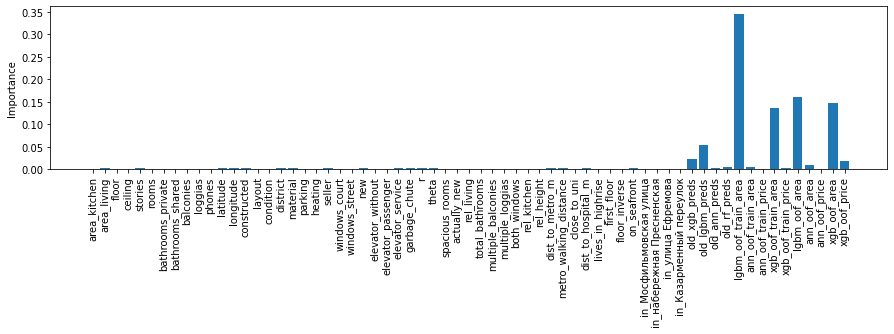

In [52]:
#plot_feature_importance(
#    train_labels.drop(["building_id", "area_total"], axis=1).columns.tolist(), best_model.feature_importances_,
#    model_type="XGBoost", figsize=(20, 4))

plt.figure(figsize=(15, 3))
plt.bar(train_labels.drop(["building_id", "area_total"], axis=1).columns.tolist(), best_model.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.show()

#### Now train on all the data!

In [ ]:
## Make a model, predicting on all the stuff. Might overfit a lot!
xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)
fit_data = xgb_model.fit(train_labels.drop(['area_total', 'building_id'],axis=1),
            np.log(price_per_square_meter),
            eval_metric='rmse',
            verbose=False,)

In [ ]:
# Training score
prediction = np.exp(xgb_model.predict(train_labels.drop(['area_total', 'building_id'],axis=1)))

In [ ]:
predict_and_store(xgb_model, test_labels.drop(["building_id", "area_total"], axis=1),
                  test, path="ensemble_predictions/stacking_on_all_data_2", exponential=True,
                  price_per_sq=True, total_area_df=test["area_total"])

##### TODO; just use all features. No need to hold back